In [57]:
#import all the necessary libraries 
import numpy as np 
import pandas as pd 
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
#read the data
file_path = "/kaggle/input/bank-data/bank_data.csv"
bank_data = pd.read_csv(file_path,index_col = "id")
#Task 1 (Regression discontinuity: banking recovery)
expected_info = bank_data.groupby("recovery_strategy").expected_recovery_amount.describe()
jumps = {}
# calculate the jumps between recovery levels (average jumps)
for i in range(1,5,1):
    jumps[i] = expected_info["mean"][i]- expected_info["mean"][i-1]
print("On average, the jump in amounts recovered for each level is")    
print(jumps)
print("These values all exceeed $50")


On average, the jump in amounts recovered for each level is
{1: 616.6991721554173, 2: 1013.0995293801261, 3: 1342.3261114375246, 4: 3055.3549901185775}
These values all exceeed $50


Graph shows that age varies smoothly with expected recovery amount


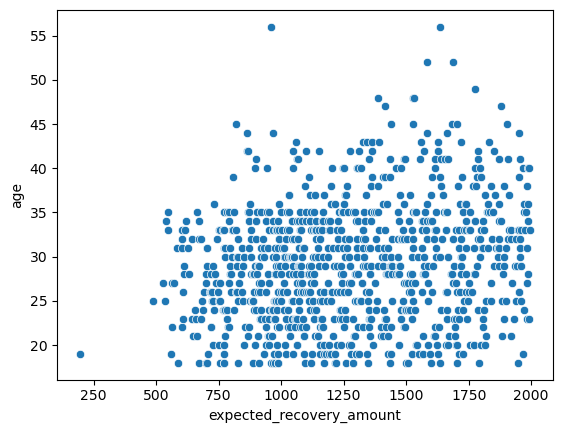

In [58]:
#Task 2 (Graphical exploratory data analysis)
X_cond = (bank_data.expected_recovery_amount >=0) & (bank_data.expected_recovery_amount <=2000)
X_data = bank_data.loc[X_cond,"expected_recovery_amount"]
y_data = bank_data.loc[X_cond,"age"]
sns.scatterplot(x = X_data,y = y_data)
print("Graph shows that age varies smoothly with expected recovery amount")

In [59]:
#Task 3 (Statistical test: age vs. expected recovery amount)
X_cond_1 = (bank_data.expected_recovery_amount >=900) & (bank_data.expected_recovery_amount <1000)
X_cond_2 = (bank_data.expected_recovery_amount >1000) & (bank_data.expected_recovery_amount <=1100)
# get the ranges just above and just below $1000 threshold
range_1 = bank_data.loc[X_cond_1,"age"] 
range_2 = bank_data.loc[X_cond_2,"age"] 
# print the average values of age in these ranges
print("Average age just below threshold: " + str(range_1.mean()))
print("Average age just above threshold: " + str(range_2.mean()))
# Use a Kruskal-Wallis test for the 2 ranges (with significance level of 0.05)
statistic, pvalue = stats.kruskal(range_1,range_2)
print("Pvalue is: {:.2f} % which is higher than 5% so there is no significant difference between the 2 ranges".format(pvalue *100))

Average age just below threshold: 27.21590909090909
Average age just above threshold: 28.68421052631579
Pvalue is: 7.55 % which is higher than 5% so there is no significant difference between the 2 ranges


In [60]:
#Task 4 (Statistical test: sex vs. expected recovery amount)
# define a method to get percentage of males in a given range
def get_percent_male(my_range):
    my_data = bank_data.loc[my_range,"sex"]
    male_count = (my_data == "Male").sum()
    total_count = my_data.count()
    percent_male = male_count * 100/total_count
    return percent_male
# use the method to get percentage of males in range: $900 to $1100
percent_1 = get_percent_male(X_cond_1)
percent_2 = get_percent_male(X_cond_2)
# print the percentages of males
print("Male percentage just below threshold: " + str(percent_1))
print("Male percentage just above threshold: " + str(percent_2))

Male percentage just below threshold: 63.63636363636363
Male percentage just above threshold: 57.89473684210526


<Axes: xlabel='expected_recovery_amount', ylabel='actual_recovery_amount'>

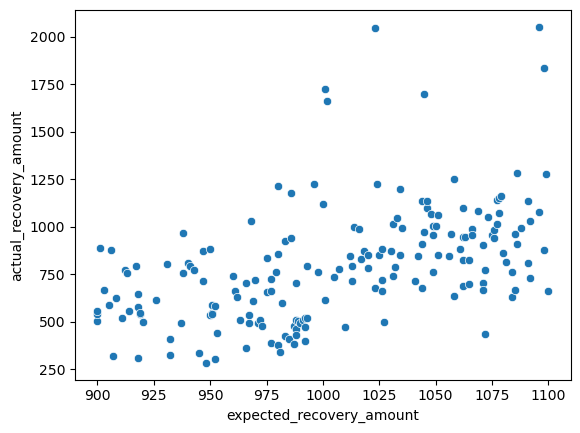

In [61]:
#Task 5 (Exploratory graphical analysis: recovery amount)
X_cond = (bank_data.expected_recovery_amount >=900) & (bank_data.expected_recovery_amount <=1100)
X_data_2 = bank_data.loc[X_cond,"expected_recovery_amount"]
y_data_2 = bank_data.loc[X_cond,"actual_recovery_amount"]
sns.scatterplot(x = X_data_2,y = y_data_2)

In [62]:
#Task 6 (Statistical analysis: recovery amount)
# get the ranges just above and just below $1000 threshold
range_3 = bank_data.loc[X_cond_1,"actual_recovery_amount"]
range_4 = bank_data.loc[X_cond_2,"actual_recovery_amount"]
# Use a Kruskal-Wallis test for the 2 ranges (with significance level of 0.05)
statistic_2, pvalue_2 = stats.kruskal(range_3,range_4)
print("Pvalue is: {:.15f} % which is extremely miniscule" .format(pvalue_2 *100))
print("That means that there is a significant difference between the 2 ranges and suggests a discontinuity in the data")
#repeat the previous steps with an even smaller range
X_cond_3 = (bank_data.expected_recovery_amount >=950) & (bank_data.expected_recovery_amount <1000)
X_cond_4 = (bank_data.expected_recovery_amount >1000) & (bank_data.expected_recovery_amount <=1050)
range_5 = bank_data.loc[X_cond_3,"actual_recovery_amount"]
range_6 = bank_data.loc[X_cond_4,"actual_recovery_amount"]
statistic_3,pvalue_3= stats.kruskal(range_5, range_6)
print("Pvalue is: {:.15f} % which is also miniscule" .format(pvalue_3*100))
print("There is still a significant difference suggesting discontinuity in the data")

Pvalue is: 0.000000000000022 % which is extremely miniscule
That means that there is a significant difference between the 2 ranges and suggests a discontinuity in the data
Pvalue is: 0.000000901355665 % which is also miniscule
There is still a significant difference suggesting discontinuity in the data


r_squared value is: 0.253
regression coefficient is: [2.69559985]


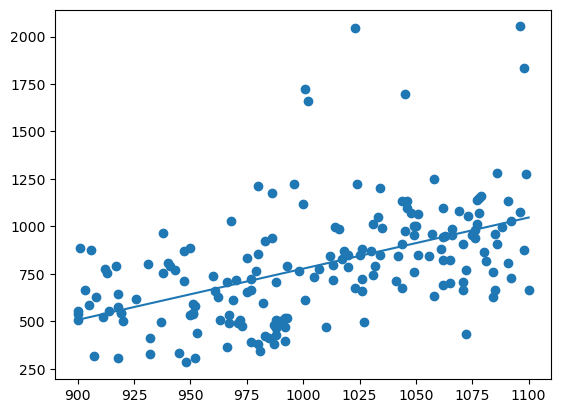

In [63]:
#Task 7 (Regression modeling: no threshold)
#select the data
X_train = pd.DataFrame(X_data_2)
y_train = y_data_2
#initialize and fit the model and use it
model_1 = linear_model.LinearRegression()
model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_train)
#plot the model
plt.plot(X_train,y_pred)
plt.scatter(X_train,y_train)
r_squared = model_1.score(X_train,y_train)
print("r_squared value is: {:.3f}".format(r_squared))
r_coef = model_1.coef_
print("regression coefficient is: " + str(r_coef))


r_squared value is: 0.298
regression coefficient due to higher recovery strategy is: 256.3424438363249
This effect is higher than the jump in cost of $50


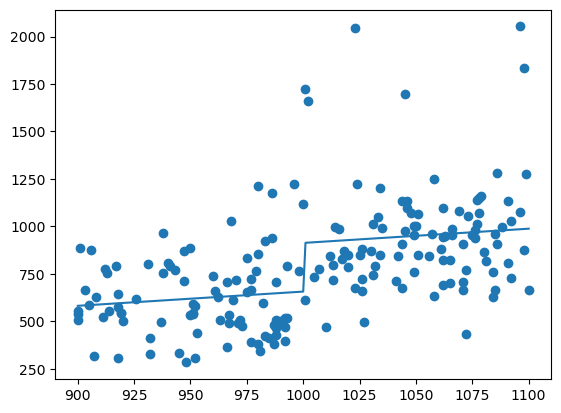

In [64]:
#Task 8 (Regression modeling: adding true threshold)
#select the data (with a threshold indicator)
X_train_2 = pd.DataFrame(X_data_2)
y_train_2 = y_data_2
threshold = 1000
thresh_ind = (X_data_2 > threshold).astype("int64")
thresh_ind.name = "thresh_ind"
X_train_2 = pd.concat([X_train,thresh_ind], axis =1) 
#initialize and fit the model and use it
model_2 = linear_model.LinearRegression()
model_2.fit(X_train_2,y_train_2)
y_pred_2 = model_2.predict(X_train_2)
#plot the model
plt.plot(X_train,y_pred_2)
plt.scatter(X_train,y_train)
r_squared_2 = model_2.score(X_train_2,y_train_2)
print("r_squared value is: {:.3f}".format(r_squared_2))
r_coef_2 = model_2.coef_[1]
print("regression coefficient due to higher recovery strategy is: " + str(r_coef_2))
print("This effect is higher than the jump in cost of $50")

r_squared value is: 0.270
regression coefficient due to higher strategy is: 229.67138617498983
This effect is higher than the jump in cost of $50


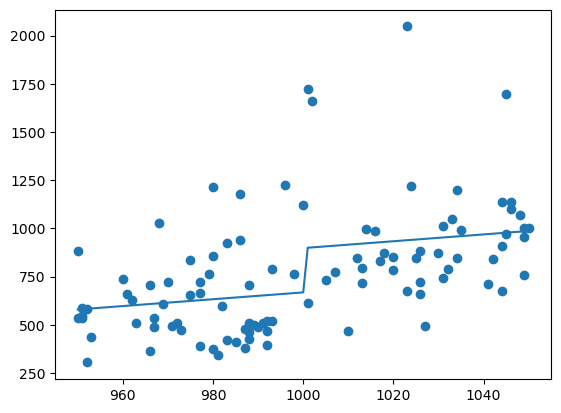

In [65]:
#Task 9 (Regression modeling: adjusting the window)
#repeat with smaller range
X_cond_5 = (bank_data.expected_recovery_amount >=950) & (bank_data.expected_recovery_amount <=1050)
X_data_3 = bank_data.loc[X_cond_5,"expected_recovery_amount"]
y_train_3 = bank_data.loc[X_cond_5,"actual_recovery_amount"] 
thresh_ind_2 = (X_data_3 > threshold).astype("int64")
thresh_ind_2.name = "thresh_ind"
X_train_3 = pd.DataFrame(X_data_3)
X_train_3 = pd.concat([X_train_3,thresh_ind_2], axis =1) 
#make a new model
model_3 = linear_model.LinearRegression()
model_3.fit(X_train_3,y_train_3)
y_pred_3 = model_3.predict(X_train_3)
#plot the model
plt.plot(X_data_3,y_pred_3)
plt.scatter(X_train_3["expected_recovery_amount"],y_train_3)
r_squared_3 = model_3.score(X_train_3,y_train_3)
print("r_squared value is: {:.3f}".format(r_squared_3))
r_coef_3 = model_3.coef_[1]
print("regression coefficient due to higher strategy is: " + str(r_coef_3))
print("This effect is higher than the jump in cost of $50")